## Unsupervised Expert Learning on Cloud Dataset

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


### Unsupervised Experts Class

In [31]:
class UnsupervisedExperts:
    def __init__(self, epochs=1, alpha=0.1):
        """
        Initialize 6 unsupervised experts (clustering algorithms) with different parameters.
        We use:
          - KMeans with 2, 3, and 4 clusters.
          - Gaussian Mixture Models (GMM) with 2, 3, and 4 components.
        """
        self.epochs = epochs
        self.alpha = alpha  # Fixed-share parameter for online updates
        
        self.experts = {
            "KMeans_2": KMeans(n_clusters=2, random_state=42),
            "KMeans_3": KMeans(n_clusters=3, random_state=42),
            "KMeans_4": KMeans(n_clusters=4, random_state=42),
            "GMM_2": GaussianMixture(n_components=2, random_state=42),
            "GMM_3": GaussianMixture(n_components=3, random_state=42),
            "GMM_4": GaussianMixture(n_components=4, random_state=42)
        }
        # To store centroids for KMeans and means for GMM experts after training
        self.cluster_centers = {}
    
    def train(self, X):
        """
        Train each unsupervised expert on the dataset X.
        For KMeans, we store the cluster centers; for GMM, we store the component means.
        """
        for name, model in self.experts.items():
            model.fit(X)
            if "KMeans" in name:
                self.cluster_centers[name] = model.cluster_centers_
            elif "GMM" in name:
                self.cluster_centers[name] = model.means_
    
    def unsupervised_loss(self, name, model, x):
        """
        Compute the loss for a single sample x using expert 'name'.
        For KMeans: loss = squared Euclidean distance from x to its assigned cluster center.
        For GMM: loss = negative log-likelihood of x.
        """
        if "KMeans" in name:
            label = model.predict(x)[0]
            center = self.cluster_centers[name][label]
            loss = np.sum((x - center)**2)
            return loss
        elif "GMM" in name:
            # score_samples returns the log-probability of the sample.
            log_prob = model.score_samples(x)[0]
            loss = -log_prob  # lower log-probability means higher loss
            return loss

    def plot_clusters(self, X, pca_components=2):
        """
        Plots the clustering result for each expert on dataset X.
        Uses PCA to reduce X to 2 dimensions for visualization.
        
        Parameters:
          X: Array of shape (n_samples, n_features)
          pca_components: Number of PCA components for plotting (default: 2)
        """
        # Reduce dimensionality using PCA
        pca = PCA(n_components=pca_components)
        X_reduced = pca.fit_transform(X)
        
        expert_names = list(self.experts.keys())
        n_experts = len(expert_names)
        
        # Create a subplot grid (2 rows x 3 columns for 6 experts)
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, name in enumerate(expert_names):
            model = self.experts[name]
            # Get cluster labels for all samples using the expert's predict method
            labels = model.predict(X)
            axes[i].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=10)
            axes[i].set_title(name + " Clusters")
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")
        plt.tight_layout()
        plt.show()

    def run(self, X):
        """
        Run the Unsupervised Experts algorithm on dataset X.
        
        Parameters:
          X: Array of shape (n_samples, n_features)
        """
        self.train(X)
        self.plot_clusters(X)

    def online_aggregation(self, X, method='static', eta=0.5):
        """
        Online aggregation for unsupervised experts.
        Processes the dataset X sample-by-sample, updating weights based on unsupervised loss.
        
        Parameters:
          X: Array of shape (n_samples, n_features)
          method: 'static' (exponential weights) or 'fixed_share'
          eta: Learning rate
        
        Returns:
          Updates self.results with:
            - weights_over_time: Array tracking weight evolution.
            - expert_losses: Per-sample loss for each expert.
            - aggregator_cum_loss: Cumulative loss over samples (weighted average loss).
            - expert_names: List of expert names.
        """
        n_experts = len(self.experts)
        n_samples = X.shape[0]
        
        # Initialize arrays for tracking metrics
        weights_over_time = np.zeros((n_samples + 1, n_experts))
        expert_losses = np.zeros((n_samples, n_experts))
        
        # Start with uniform weights
        weights = np.ones(n_experts) / n_experts
        weights_over_time[0] = weights.copy()
        
        expert_names = list(self.experts.keys())
        
        for t in range(n_samples):
            x_t = X[t].reshape(1, -1)
            
            # Compute unsupervised loss for each expert on x_t
            for i, name in enumerate(expert_names):
                loss = self.unsupervised_loss(name, self.experts[name], x_t)
                expert_losses[t, i] = loss
            
            # Update weights based on losses
            if method == 'static':
                updated_weights = weights * np.exp(-eta * expert_losses[t, :])
                weights = updated_weights / np.sum(updated_weights)
            elif method == 'fixed_share':
                updated_weights = weights * np.exp(-eta * expert_losses[t, :])
                shared_weights = self.alpha * np.mean(updated_weights)
                updated_weights = (1 - self.alpha) * updated_weights + shared_weights
                weights = updated_weights / np.sum(updated_weights)
            else:
                raise ValueError("Method must be 'static' or 'fixed_share'")
            
            weights_over_time[t + 1] = weights.copy()
        
        # Define aggregator loss as the weighted average of expert losses at each sample.
        aggregator_losses = np.sum(weights_over_time[1:] * expert_losses, axis=1)
        aggregator_cum_loss = np.cumsum(aggregator_losses)
        
        self.results = {
            "weights_over_time": weights_over_time,
            "expert_cum_loss": expert_losses,
            "aggregator_cum_loss": aggregator_cum_loss,
            "expert_names": expert_names
        }
    
    def plot_aggregator_info(self):
        """
        Plots aggregator and expert information from online aggregation.
        
        This includes:
          - The evolution of expert weights over iterations.
          - The cumulative loss of the aggregator vs. iterations,
            alongside the cumulative losses of each expert.
        """
        weights = self.results["weights_over_time"]
        aggregator_cum_loss = self.results["aggregator_cum_loss"]
        expert_cum_loss = np.cumsum(self.results["expert_cum_loss"], axis=0)
        expert_names = self.results["expert_names"]
        
        n_samples = weights.shape[0] - 1

        plt.figure(figsize=(12, 8))
        # Plot weights evolution
        plt.subplot(2, 1, 1)
        for i, name in enumerate(expert_names):
            plt.plot(range(n_samples + 1), weights[:, i], label=name)
        plt.xlabel("Iteration")
        plt.ylabel("Weight")
        plt.title("Evolution of Expert Weights (Unsupervised)")
        plt.legend()
        plt.grid(True)
        
        # Plot cumulative losses
        plt.subplot(2, 1, 2)
        plt.plot(range(n_samples), aggregator_cum_loss, label="Aggregator Cumulative Loss", 
                 linewidth=2, color="black")
        for i, name in enumerate(expert_names):
            plt.plot(range(n_samples), expert_cum_loss[:, i], 
                    label=f"{name} Cumulative Loss", linestyle="--")
        plt.xlabel("Iteration")
        plt.ylabel("Cumulative Loss")
        plt.title("Cumulative Loss vs. Iterations (Unsupervised)")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

### Import Dataset

In [32]:
# fetch dataset 
cloud = fetch_ucirepo(id=155)

# data (as pandas dataframe)
cloud_X = cloud.data.features  # Cloud dataset is unlabeled

# convert features to a NumPy array
X_cloud = cloud_X.to_numpy()

# Since there are no labels, we split only X_cloud into train and test sets (80-20 split)
X_cloud_train, X_cloud_test = train_test_split(X_cloud, test_size=0.2, random_state=42)

# Scale features
scaler_spam = StandardScaler().fit(X_cloud_train)
X_train = scaler_spam.transform(X_cloud_train)
X_test = scaler_spam.transform(X_cloud_test)

### Offline Training and Evaluation of Experts

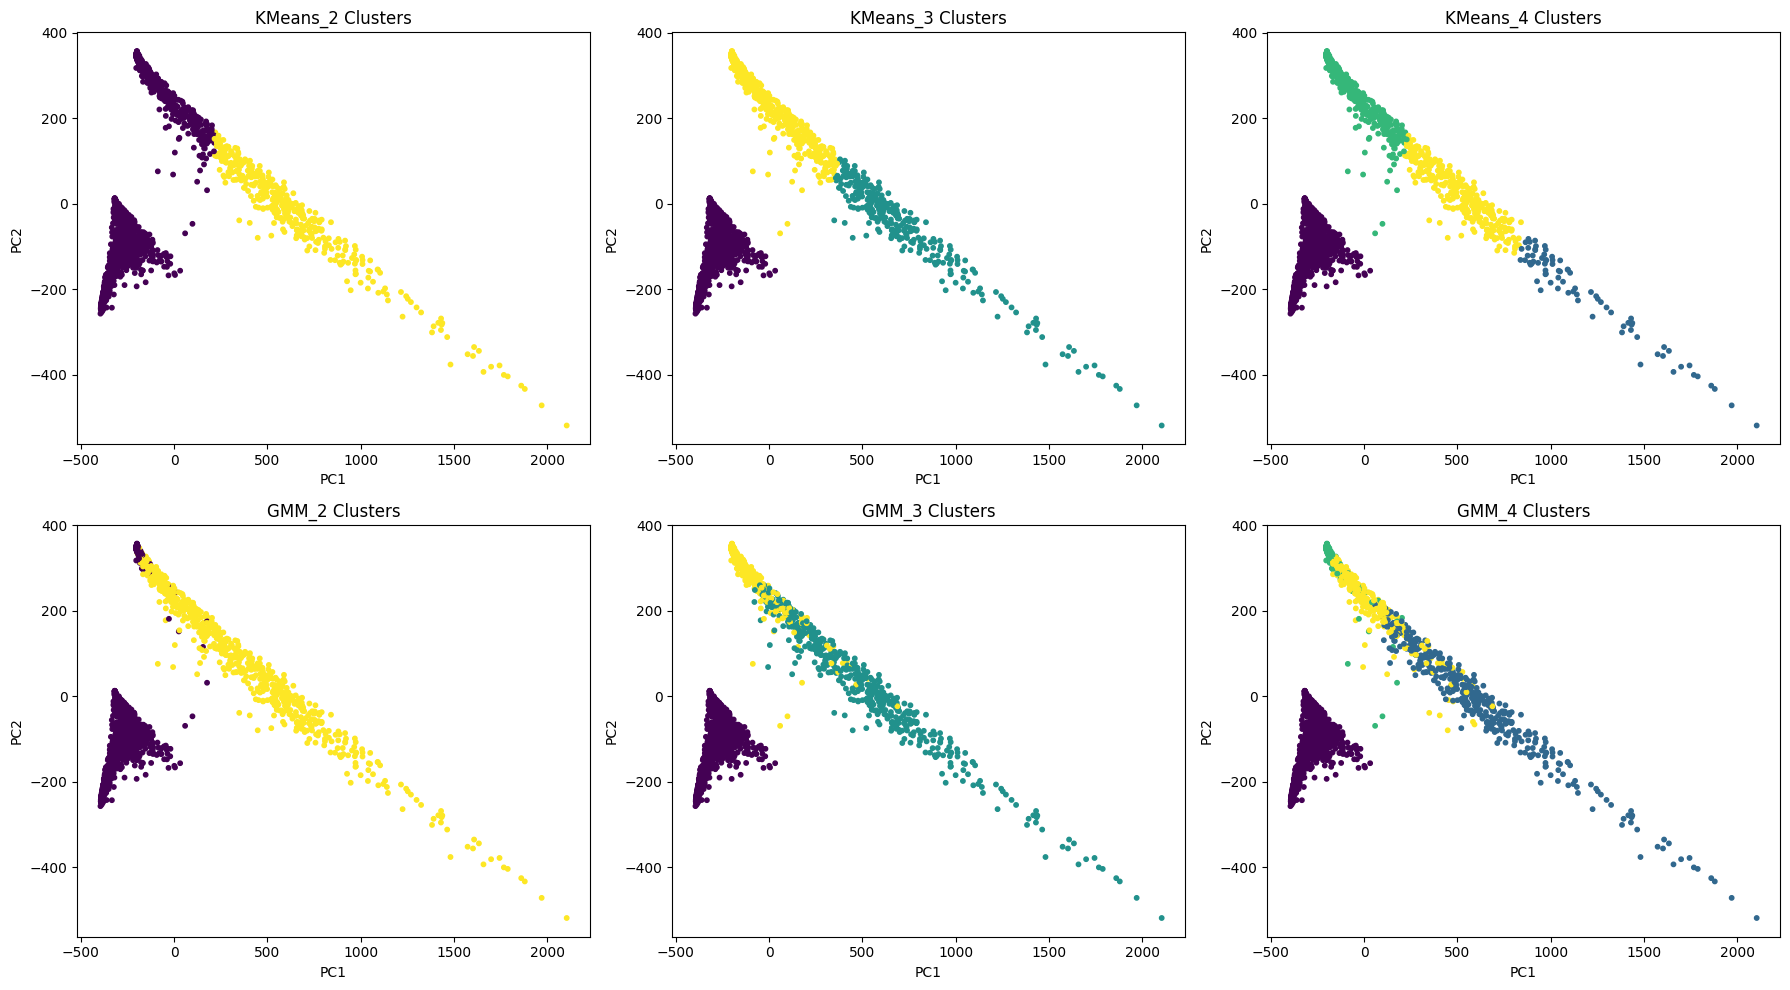

In [33]:
# Run the expert offline model training of unsupervised experts
experts = UnsupervisedExperts(epochs=1)
experts.run(X_cloud_train)

### Online Training and Evaluation of Experts

#### Static Weight Share

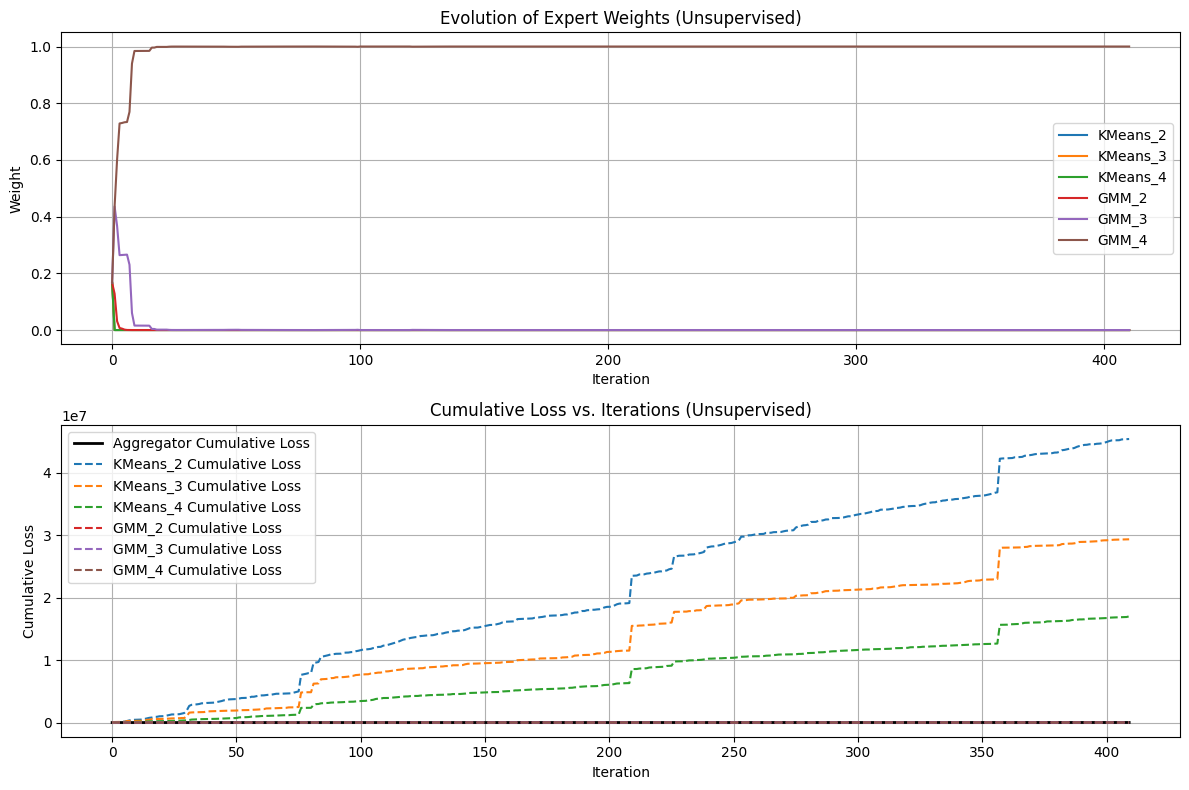

In [34]:
# Run online aggregation on the test set
experts.online_aggregation(X_cloud_test, method='static', eta=0.5)
# Plot the evolution of expert weights and the cumulative aggregator loss
experts.plot_aggregator_info()

#### Fixed Weight Share

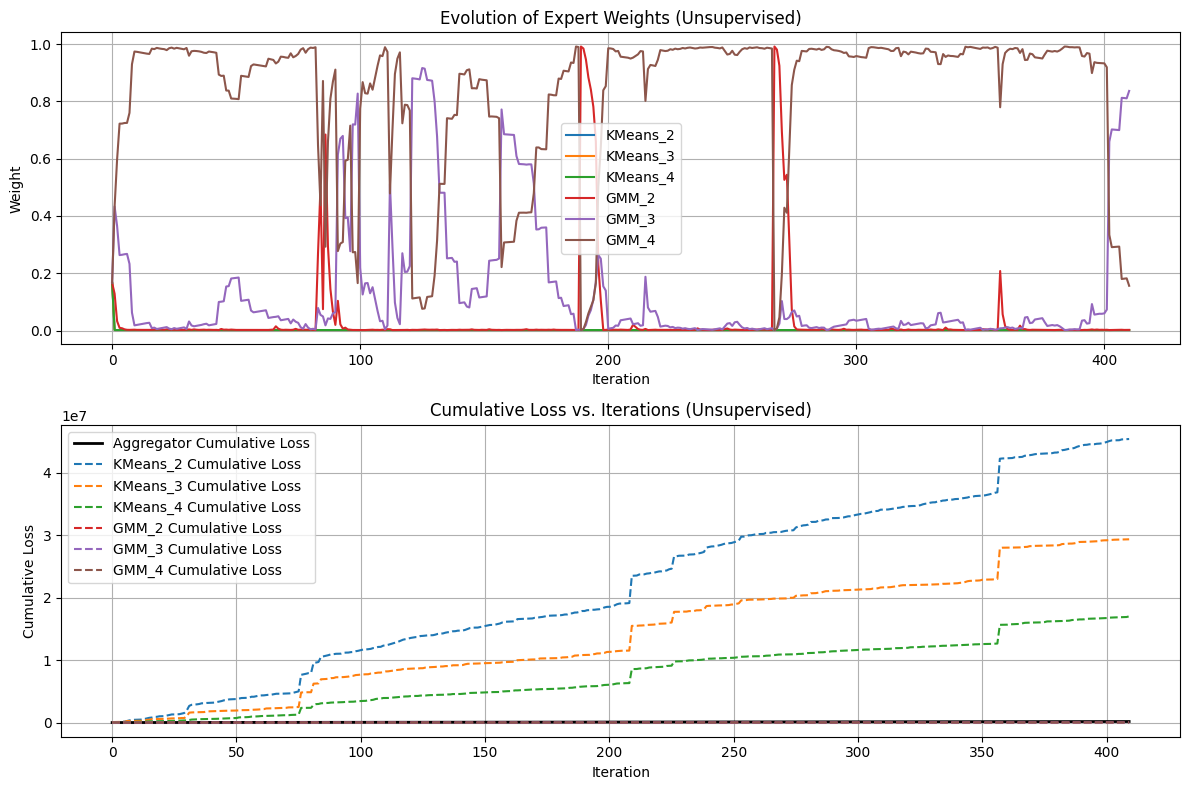

In [35]:
experts.alpha = 0.01
experts.online_aggregation(X_cloud_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()

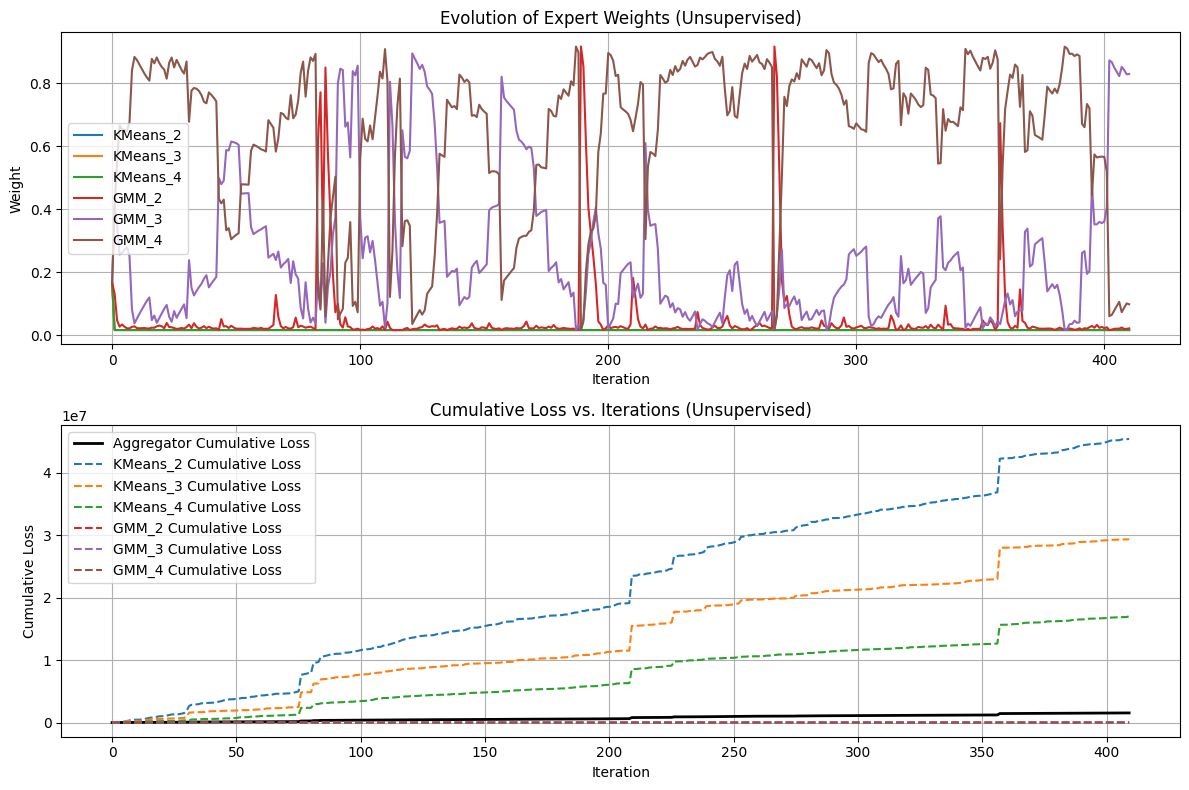

In [36]:
experts.alpha = 0.1
experts.online_aggregation(X_cloud_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()

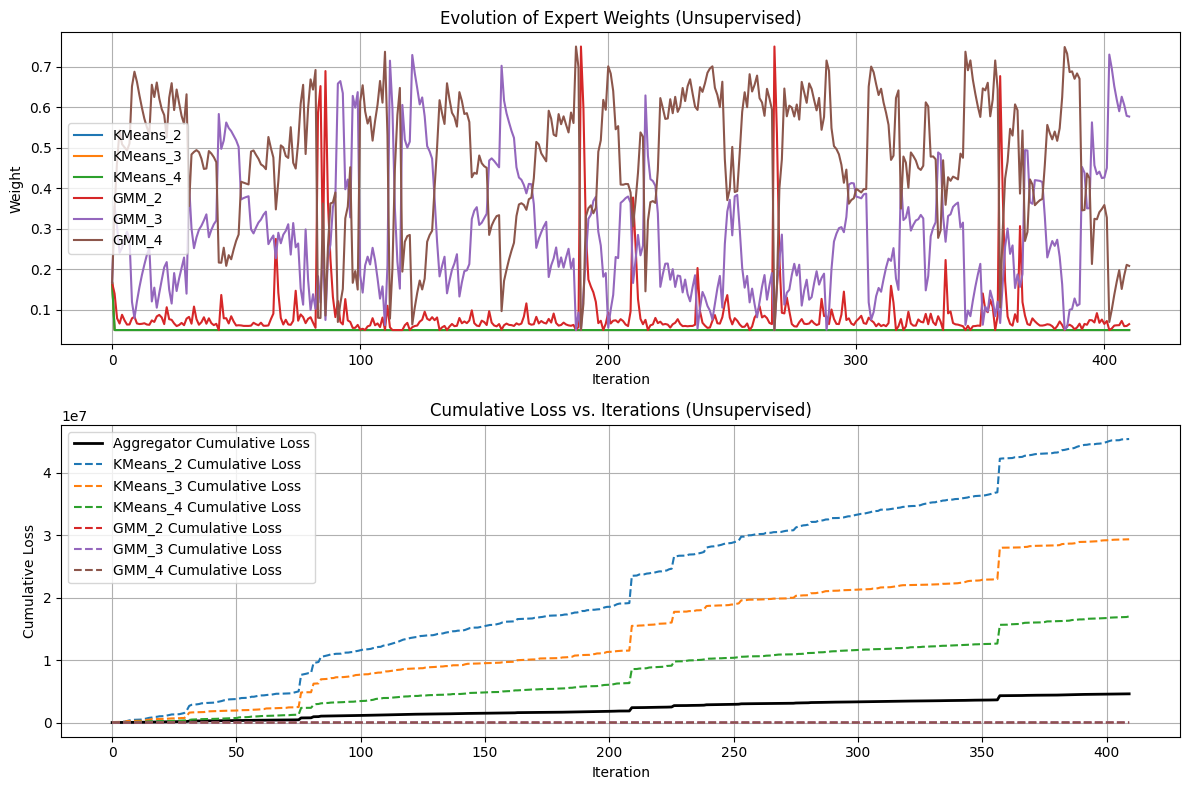

In [37]:
experts.alpha = 0.3
experts.online_aggregation(X_cloud_test, method='fixed_share', eta=0.5)
experts.plot_aggregator_info()